<a href="https://colab.research.google.com/github/bernia/MachineLearning/blob/master/tf_tutorials/text_class_w_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Text classification with preprocessed text: Movie reviews

In [1]:
# Imports
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

!pip install -q tensorflow-datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

     |████████████████████████████████| 467.6MB 31kB/s 
     |████████████████████████████████| 460kB 54.1MB/s 
     |████████████████████████████████| 2.9MB 33.9MB/s 
     |████████████████████████████████| 3.9MB 31.6MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.1 which is incompatible.
2.2.0-dev20200212


In [2]:
# Load the dataset
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU8NOO3/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU8NOO3/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteU8NOO3/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [5]:
# Encoder examples

encoder = info.features['text'].encoder

print('Tamaño de vocabulario: {}'.format(encoder.vocab_size))

sample_string = 'Hello TensorWorld'

encoded_string = encoder.encode(sample_string)
print('Encoded string is: {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('Original string is: {}'.format(original_string))

assert original_string == sample_string

for ts in encoded_string:
  print('{} -----> {}'.format(ts,encoder.decode([ts])))

Tamaño de vocabulario: 8185
Encoded string is: [4025, 222, 6307, 2327, 2307, 1829]
Original string is: Hello TensorWorld
4025 -----> Hell
222 -----> o 
6307 -----> Ten
2327 -----> sor
2307 -----> Wor
1829 -----> ld


In [8]:
# Explorando los datos

for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

  print(encoder.decode(train_example))

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.


In [11]:
# Preparar los datos para entrenar

BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))

test_batches = (
    test_data
    .padded_batch(32))

for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (32, 958)
label shape: (32,)
Batch shape: (32, 1231)
label shape: (32,)


In [13]:
# Model Design

model = keras.Sequential([
                          keras.layers.Embedding(encoder.vocab_size,16),
                          keras.layers.GlobalAveragePooling1D(),
                          keras.layers.Dense(1)])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# Model training

history = model.fit(train_batches,epochs=10,validation_data=test_batches,validation_steps=30)

Epoch 1/10
782/782 [==============================] - 13s 17ms/step - loss: 0.6813 - accuracy: 0.5005 - val_loss: 0.6630 - val_accuracy: 0.5042
Epoch 2/10
782/782 [==============================] - 10s 13ms/step - loss: 0.6192 - accuracy: 0.5551 - val_loss: 0.5935 - val_accuracy: 0.5781
Epoch 3/10
782/782 [==============================] - 10s 13ms/step - loss: 0.5393 - accuracy: 0.6682 - val_loss: 0.5311 - val_accuracy: 0.6990
Epoch 4/10
782/782 [==============================] - 10s 13ms/step - loss: 0.4733 - accuracy: 0.7511 - val_loss: 0.4813 - val_accuracy: 0.7437
Epoch 5/10
782/782 [==============================] - 11s 13ms/step - loss: 0.4210 - accuracy: 0.8004 - val_loss: 0.4449 - val_accuracy: 0.8198
Epoch 6/10
782/782 [==============================] - 10s 13ms/step - loss: 0.3799 - accuracy: 0.8336 - val_loss: 0.4160 - val_accuracy: 0.8125
Epoch 7/10
782/782 [==============================] - 10s 13ms/step - loss: 0.3476 - accuracy: 0.8550 - val_loss: 0.3959 - val_accuracy:

In [17]:
loss, accuracy = model.evaluate(test_batches)
print()
print("Loss: ",loss)
print("Accuracy: ",accuracy)

    782/Unknown - 7s 9ms/step - loss: 0.3329 - accuracy: 0.8471
Loss:  0.3328687348748412
Accuracy:  0.84708


In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

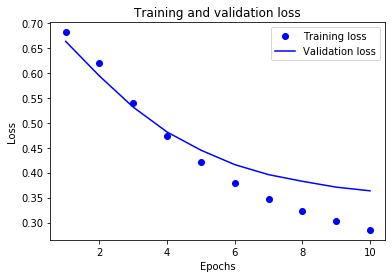

In [21]:
# Graph of history values over time

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

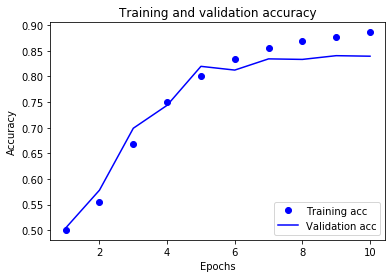

In [22]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [0]:
# The model seems to be overfitted because it performs better on the training data than on data that has never seen before.